# Read Data

In [3]:
!pip install emoji

     |████████████████████████████████| 133kB 6.9MB/s 


In [4]:
!pip install textblob

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from spacy.lang.id import Indonesian
import emoji

from textblob import TextBlob as tb

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn import model_selection, svm

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize 

import re
import string

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [6]:
# Fungsi F1 Macro Score
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [7]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [8]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [9]:
train.head()

,review_id,review_text,category
0,0fc651bfdd38a3b4ba19ef9d0d1e92e3,"Penginapannya rapi, bersih, suasana tenang, pe...",1
1,7d8cb2e465c5602e51c1ba8710e8ff16,"wifi tidak sampai kamar, tidak tersedia heater...",0
2,1f4447c73e5e1aac462d05b0ecbd5a55,"Lantai kamar mandi kotor, bau, dan seperti sdh...",0
3,b9aefbfb0debbfff43f8b268c82b43c0,"Wc jorok.. Kasur tidak dibersihkan,, handuk ti...",0
4,e2afef18bd695fae43d4d53b8c547bd4,bocor lagi,0


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14856 entries, 0 to 14855
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    14856 non-null  object
 1   review_text  14856 non-null  object
 2   category     14856 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 348.3+ KB


# EDA Before Preprocessing

In [11]:
train.nunique()

review_id      14856
review_text    14856
category           2
dtype: int64

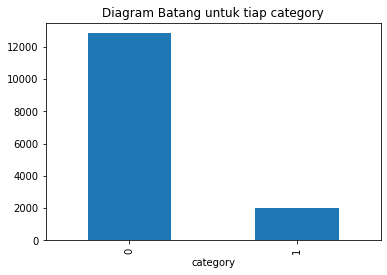

In [12]:
train.groupby('category').count()['review_id'].plot(kind='bar', title="Diagram Batang untuk tiap category")

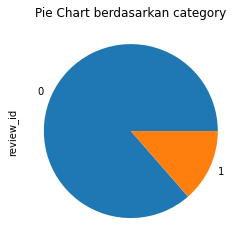

In [13]:
train.groupby('category').count()['review_id'].plot(kind='pie', title="Pie Chart berdasarkan category")

Text(0.5, 1.0, 'Pie Chart berdasarkan category')

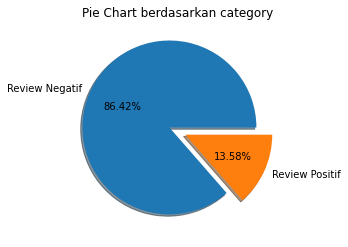

In [14]:
labels= ["Review Negatif", "Review Positif"]
plt.pie(train.groupby('category').count()['review_id'], labels=labels, shadow=True,explode=(0.1,  0.1), autopct='%1.2f%%')
plt.title("Pie Chart berdasarkan category")

In [15]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=100,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

# WORDCLOUD

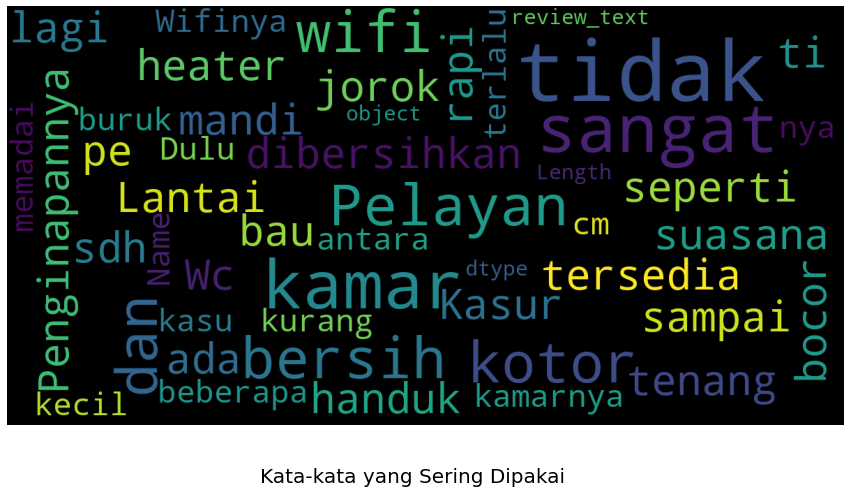

In [16]:
show_wordcloud(train['review_text'],'Kata-kata yang Sering Dipakai')

# Negative Review

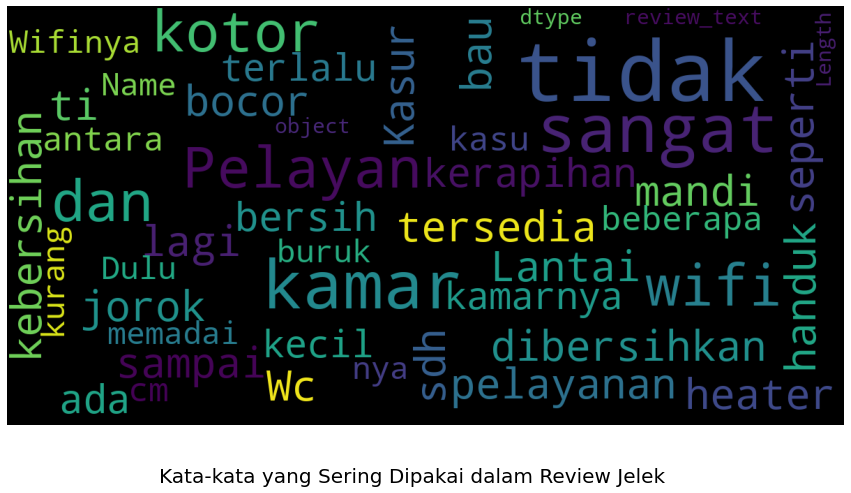

In [17]:
show_wordcloud(train[train['category'] == 0]['review_text'],'Kata-kata yang Sering Dipakai dalam Review Jelek')

# Positive Review

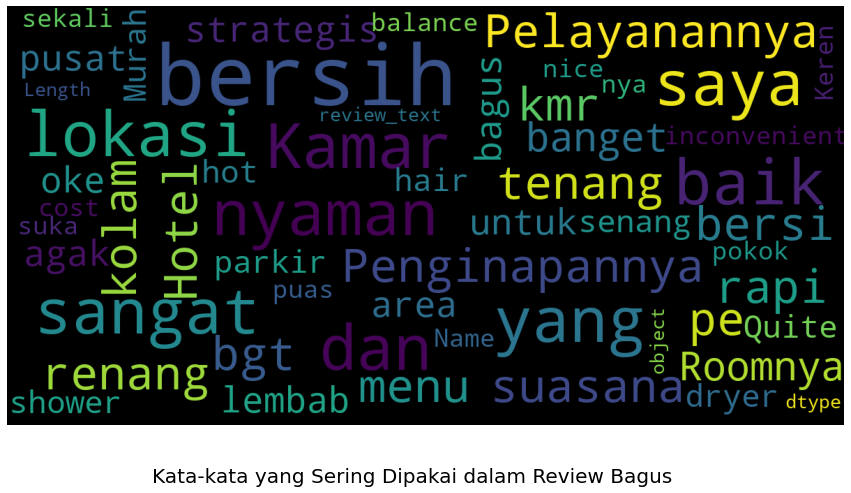

In [18]:
show_wordcloud(train[train['category'] == 1]['review_text'],'Kata-kata yang Sering Dipakai dalam Review Bagus')

In [19]:
train['length'] = train['review_text'].apply(len)
train.head()

,review_id,review_text,category,length
0,0fc651bfdd38a3b4ba19ef9d0d1e92e3,"Penginapannya rapi, bersih, suasana tenang, pe...",1,194
1,7d8cb2e465c5602e51c1ba8710e8ff16,"wifi tidak sampai kamar, tidak tersedia heater...",0,159
2,1f4447c73e5e1aac462d05b0ecbd5a55,"Lantai kamar mandi kotor, bau, dan seperti sdh...",0,227
3,b9aefbfb0debbfff43f8b268c82b43c0,"Wc jorok.. Kasur tidak dibersihkan,, handuk ti...",0,59
4,e2afef18bd695fae43d4d53b8c547bd4,bocor lagi,0,10


In [20]:
train_pos= train[train['category'] == 1]
train_pos.head()

,review_id,review_text,category,length
0,0fc651bfdd38a3b4ba19ef9d0d1e92e3,"Penginapannya rapi, bersih, suasana tenang, pe...",1,194
7,b0a8cb904f0536dca57bd5be090e510c,"Pelayanannya sangat baik,kmr yang bersih,menu ...",1,99
12,d6fd462ba09d87510ac1d767b68d1d68,Hotel bersih bgt...nyaman...kolam renang bersi...,1,174
13,0ce78b57274ab55b29860f62f16ebfbb,"Roomnya bersih banget, lokasi strategis pusat ...",1,165
28,f95c715acd1912c10dbe0f27f3bbd81c,"Kamar agak lembab, lokasi oke.",1,30


In [21]:
train_pos['length'].describe()

count    2017.000000
mean       89.631135
std        72.174576
min        21.000000
25%        44.000000
50%        69.000000
75%       100.000000
max       656.000000
Name: length, dtype: float64

In [22]:
train_pos[train_pos['length'] == 656]['review_text'].iloc[0]

"This review is great if you are catching the ferry to Nusa Lembongan or the other islands. It is perfect to walk out the next morning and board the boats. No taxi, no luggage hassles.  But it is situated next to a fish restaurant and has its 'Airy' name must include the smell of fish and cooking seafood. Rooms 1, 2 and three without heaps of deodorant smell of fish. Room 24 has a great view and only has cooking smells. Don’t expect workable wifi, it needs an overhaul. I only found workable wifi twice late at night. The staff are friendly and helpful but they don’t have a solution for the wifi. It has a lovely court yard. Looks a tropical paradise. "

In [23]:
train_neg= train[train['category'] == 0]
train_neg.head()

,review_id,review_text,category,length
1,7d8cb2e465c5602e51c1ba8710e8ff16,"wifi tidak sampai kamar, tidak tersedia heater...",0,159
2,1f4447c73e5e1aac462d05b0ecbd5a55,"Lantai kamar mandi kotor, bau, dan seperti sdh...",0,227
3,b9aefbfb0debbfff43f8b268c82b43c0,"Wc jorok.. Kasur tidak dibersihkan,, handuk ti...",0,59
4,e2afef18bd695fae43d4d53b8c547bd4,bocor lagi,0,10
5,a45d79bde831ad1306adbd8ffb5d3d50,"kebersihan, pelayanan, kerapihan",0,32


# Baseline Model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train['review_text'], 
                                                 train.category, test_size=0.3, 
                                                 random_state=2020)

In [ ]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("f1-score micro: {}".format(f1_score(y_test, prediction, average='macro')))

print("accuracy train: {}%".format(round(accuracy_score(y_train, model.predict(X_train))*100,2)))
print("f1-score macro train: {}".format(f1_score(y_train, model.predict(X_train), average='macro')))

accuracy: 93.61%
f1-score micro: 0.8421076183296343
accuracy train: 94.88%
f1-score macro train: 0.8720092045262313


In [ ]:
pipe = Pipeline([('vect', TfidfVectorizer()),
                 ('model', LogisticRegression())])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("f1-score micro: {}".format(f1_score(y_test, prediction, average='macro')))

print("accuracy train: {}%".format(round(accuracy_score(y_train, model.predict(X_train))*100,2)))
print("f1-score macro train: {}".format(f1_score(y_train, model.predict(X_train), average='macro')))

accuracy: 93.61%
f1-score micro: 0.8421076183296343
accuracy train: 94.88%
f1-score macro train: 0.8720092045262313


In [ ]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model',SGDClassifier())])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("f1-score micro: {}".format(f1_score(y_test, prediction, average='macro')))

print("accuracy train: {}%".format(round(accuracy_score(y_train, model.predict(X_train))*100,2)))
print("f1-score macro train: {}".format(f1_score(y_train, model.predict(X_train), average='macro')))

accuracy: 94.17%
f1-score micro: 0.8651813760848827
accuracy train: 97.12%
f1-score macro train: 0.9332265025866946


In [ ]:
pipe = Pipeline([('vect', TfidfVectorizer()),
                 ('model', SGDClassifier())])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("f1-score micro: {}".format(f1_score(y_test, prediction, average='macro')))

print("accuracy train: {}%".format(round(accuracy_score(y_train, model.predict(X_train))*100,2)))
print("f1-score macro train: {}".format(f1_score(y_train, model.predict(X_train), average='macro')))

accuracy: 94.3%
f1-score micro: 0.8670441007351062
accuracy train: 96.99%
f1-score macro train: 0.9299329431757968


In [ ]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', svm.SVC())])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("f1-score micro: {}%".format(f1_score(y_test, prediction, average='macro')))

print("accuracy train: {}%".format(round(accuracy_score(y_train, model.predict(X_train))*100,2)))
print("f1-score macro train: {}%".format(f1_score(y_train, model.predict(X_train), average='macro')))

accuracy: 94.1%
f1-score micro: 0.858157168920233%
accuracy train: 98.52%
f1-score macro train: 0.9667005044477066%


# Preprocessing

In [24]:
have_emoji_train_idx = []
have_emoji_test_idx = []

for idx, review in enumerate(train['review_text']):
    if any(char in emoji.UNICODE_EMOJI for char in review):
        have_emoji_train_idx.append(idx)
        
for idx, review in enumerate(test['review_text']):
    if any(char in emoji.UNICODE_EMOJI for char in review):
        have_emoji_test_idx.append(idx)

In [25]:
train_emoji_percentage = round(len(have_emoji_train_idx) / train.shape[0] * 100, 2)
print(f'Train data has {len(have_emoji_train_idx)} rows that used emoji, that means {train_emoji_percentage} percent of the total')

test_emoji_percentage = round(len(have_emoji_test_idx) / test.shape[0] * 100, 2)
print(f'Test data has {len(have_emoji_test_idx)} rows that used emoji, that means {test_emoji_percentage} percent of the total')

Train data has 0 rows that used emoji, that means 0.0 percent of the total
Test data has 0 rows that used emoji, that means 0.0 percent of the total


In [26]:
def review_cleaning(text):
    
    # lowercase text and delete newline
    text = text.lower()
    text = re.sub(r'\n', '', text)
    
    # change emoticon to text
    text = re.sub(r':\(', 'dislike', text)
    text = re.sub(r': \(\(', 'dislike', text)
    text = re.sub(r':, \(', 'dislike', text)
    text = re.sub(r':\)', 'smile', text)
    text = re.sub(r';\)', 'smile', text)
    text = re.sub(r':\)\)\)', 'smile', text)
    text = re.sub(r':\)\)\)\)\)\)', 'smile', text)
    text = re.sub(r'=\)\)\)\)', 'smile', text)
    
    # Delete repeated character
    text = re.sub(r'(\w)\1{2,}', r'\1', text)
    
    # Delete number
    text = re.sub(r'\d+', '', text)
    
    # Substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)
    
    # Remove all the special characters
    text = re.sub(r'\W', ' ', text)
    
    # remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    # Remove single characters from the start
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    
    # delete punctuation
    text = re.sub('[^a-z0-9 ]', ' ', text)

    tokenizer = text.split()
    
    text = ' '.join([WordNetLemmatizer().lemmatize(text) for text in tokenizer])
    
    #text = stemmer.stem(text)
    
    return text

In [30]:
train['review_text'] = train['review_text'].apply(review_cleaning)
test['review_text'] = test['review_text'].apply(review_cleaning)

In [31]:
train['length'] = train['review_text'].apply(len)
train.head()

,review_id,review_text,category,length
0,0fc651bfdd38a3b4ba19ef9d0d1e92e3,penginapannya rapi bersih suasana tenang pelay...,1,188
1,7d8cb2e465c5602e51c1ba8710e8ff16,wifi tidak sampai kamar tidak tersedia heater ...,0,158
2,1f4447c73e5e1aac462d05b0ecbd5a55,lantai kamar mandi kotor bau dan seperti sdh j...,0,218
3,b9aefbfb0debbfff43f8b268c82b43c0,wc jorok kasur tidak dibersihkan handuk tidak ...,0,53
4,e2afef18bd695fae43d4d53b8c547bd4,bocor lagi,0,10


In [32]:
train = train[(train['length'] > 2) | (train['length'] == 0)]

In [33]:
train[train['length'] == 1]

,review_id,review_text,category,length


In [34]:
# drop the row that has noisy text or mislabeled rating
noisy_row = [924, 232, 2195, 2799, 8076, 12093, 12549, 13321, 14726, 2899, 3148, 
             3300, 7548, 8335, 11997, 12413, 12513, 14638, 2444, 1056, 12229, 5674, 12489, 2366, 11519,
            11525, 14576, 2614, 10641, 10322, 7782, 7620, 4265]

train.drop(noisy_row, inplace=True)

In [35]:
def recover_shortened_words(text):
    
    # put \b (boundary) for avoid the characters in the word to be replaced
    # I only make a few examples here, you can add if you're interested :)
    
    text = re.sub(r'\bg\b', 'tidak', text)
    text = re.sub(r'\benk\b', 'enak', text)
    text = re.sub(r'\bgak\b', 'tidak', text)
    text = re.sub(r'\bga\b', 'tidak', text)
    text = re.sub(r'\bgk\b', 'tidak', text)
    text = re.sub(r'\btdak\b', 'tidak', text)
    text = re.sub(r'\btdk\b', 'tidak', text)
    text = re.sub(r'\bngga\b', 'tidak', text)
    
    text = re.sub(r'\byg\b', 'yang', text)
    text = re.sub(r'\bjd\b', 'jadi', text)
    
    text = re.sub(r'\bribet\b', 'rumit', text)
    text = re.sub(r'\bruwet\b', 'rumit', text)
    text = re.sub(r'\briweuh\b', 'rumit', text)
    
    text = re.sub(r'\bscary\b', 'seram', text)
    text = re.sub(r'\bangker\b', 'seram', text)
    text = re.sub(r'\bcreepy\b', 'seram', text)
    text = re.sub(r'\bserem\b', 'seram', text)
    
    text = re.sub(r'\bsepit\b', 'sempit', text)
    text = re.sub(r'\bsumpek\b', 'sempit', text)
    text = re.sub(r'\bsenpit\b', 'sempit', text)
    text = re.sub(r'\bsempiit\b', 'sempit', text)
    
    text = re.sub(r'\bbagis\b', 'bagus', text)
    
    text = re.sub(r'\bbig no\b', 'jelek', text)
    text = re.sub(r'\belek\b', 'jelek', text)
    
    text = re.sub(r'\bok aja\b', 'biasa', text)
    text = re.sub(r'\bb aja\b', 'biasa', text)
    
    text = re.sub(r'\bso sad	\b', 'sedih', text)
    
    text = re.sub(r'\bkeceea\b', 'kecewa', text)
    text = re.sub(r'\bk c w a\b', 'kecewa', text)
    text = re.sub(r'\bkecewaa\b', 'kecewa', text)
    text = re.sub(r'\bkecews \b', 'kecewa', text)
    
    text = re.sub(r'\bbrisik\b', 'bising', text)
    text = re.sub(r'\bberisik\b', 'bising', text)
    
    text = re.sub(r'\bpengapp\b', 'pengap', text)
    
    text = re.sub(r'\bwifi\b', 'no wifi', text)
    
    text = re.sub(r'\blamabat\b', 'lambat', text)
    
    text = re.sub(r'\bpelayana\b', 'pelayanan', text)
    text = re.sub(r'\bpelayananx\b', 'pelayanan', text)
    text = re.sub(r'\bkamarx\b', 'kamar', text)
    text = re.sub(r'\bbauk\b', 'bau', text)
    
    text = re.sub(r'\bbaad\b', 'bad', text)
    
    text = re.sub(r'\bbgt\b', 'banget', text)
    text = re.sub(r'\bbgd\b', 'banget', text)
    
    text = re.sub(r'\blg\b', 'lagi', text)
    
    text = re.sub(r'\bbyk\b', 'banyak', text)
    
    text = re.sub(r'\bkmr\b', 'kamar', text)
    
    text = re.sub(r'\btmptnya\b', 'tempatnya', text)
    
    return text

In [36]:
train['review_text'] = train['review_text'].apply(recover_shortened_words)
test['review_text'] = test['review_text'].apply(recover_shortened_words)

In [37]:
train.head()

,review_id,review_text,category,length
0,0fc651bfdd38a3b4ba19ef9d0d1e92e3,penginapannya rapi bersih suasana tenang pelay...,1,188
1,7d8cb2e465c5602e51c1ba8710e8ff16,no wifi tidak sampai kamar tidak tersedia heat...,0,158
2,1f4447c73e5e1aac462d05b0ecbd5a55,lantai kamar mandi kotor bau dan seperti sdh j...,0,218
3,b9aefbfb0debbfff43f8b268c82b43c0,wc jorok kasur tidak dibersihkan handuk tidak ...,0,53
4,e2afef18bd695fae43d4d53b8c547bd4,bocor lagi,0,10


# EDA After Preprocessing

# WORDCLOUD

In [38]:
neg = train[train['category'] == 0]['review_text']
pos = train[train['category'] == 1]['review_text']

neg_text = ' '.join([text for text in neg])
pos_text = ' '.join([text for text in pos])

## Negative Review

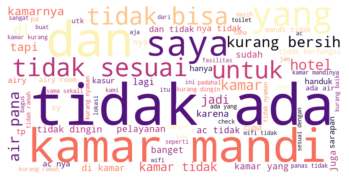

In [39]:
from wordcloud import WordCloud, ImageColorGenerator

neg_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma', max_words=80).generate(neg_text)

plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Positive Review 

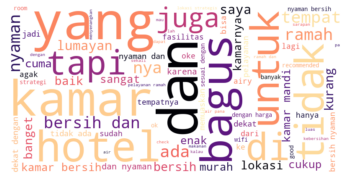

In [40]:
from wordcloud import WordCloud, ImageColorGenerator

pos_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma', max_words=80).generate(pos_text)

plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14800 entries, 0 to 14855
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    14800 non-null  object
 1   review_text  14800 non-null  object
 2   category     14800 non-null  int64 
 3   length       14800 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 578.1+ KB


# Model after preprocessing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train['review_text'], 
                                                 train.category, test_size=0.3, 
                                                 random_state=2020)

In [ ]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("f1-score micro: {}".format(f1_score(y_test, prediction, average='macro')))

print("accuracy train: {}%".format(round(accuracy_score(y_train, model.predict(X_train))*100,2)))
print("f1-score macro train: {}".format(f1_score(y_train, model.predict(X_train), average='macro')))

accuracy: 93.49%
f1-score micro: 0.8408983176878055
accuracy train: 95.18%
f1-score macro train: 0.8794867812153478


In [ ]:
pipe = Pipeline([('vect', TfidfVectorizer()),
                 ('model', LogisticRegression())])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("f1-score micro: {}".format(f1_score(y_test, prediction, average='macro')))

print("accuracy train: {}%".format(round(accuracy_score(y_train, model.predict(X_train))*100,2)))
print("f1-score macro train: {}".format(f1_score(y_train, model.predict(X_train), average='macro')))

accuracy: 93.49%
f1-score micro: 0.8408983176878055
accuracy train: 95.18%
f1-score macro train: 0.8794867812153478


In [ ]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model',SGDClassifier())])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("f1-score micro: {}".format(f1_score(y_test, prediction, average='macro')))

print("accuracy train: {}%".format(round(accuracy_score(y_train, model.predict(X_train))*100,2)))
print("f1-score macro train: {}".format(f1_score(y_train, model.predict(X_train), average='macro')))

accuracy: 94.23%
f1-score micro: 0.866558408168038
accuracy train: 96.94%
f1-score macro train: 0.9281238904503668


In [ ]:
pipe = Pipeline([('vect', TfidfVectorizer()),
                 ('model', SGDClassifier())])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("f1-score micro: {}".format(f1_score(y_test, prediction, average='macro')))

print("accuracy train: {}%".format(round(accuracy_score(y_train, model.predict(X_train))*100,2)))
print("f1-score macro train: {}".format(f1_score(y_train, model.predict(X_train), average='macro')))

accuracy: 94.26%
f1-score micro: 0.8669751389670376
accuracy train: 96.88%
f1-score macro train: 0.9266120815311465


In [ ]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', svm.SVC())])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("f1-score micro: {}".format(f1_score(y_test, prediction, average='macro')))

print("accuracy train: {}%".format(round(accuracy_score(y_train, model.predict(X_train))*100,2)))
print("f1-score macro train: {}".format(f1_score(y_train, model.predict(X_train), average='macro')))

accuracy: 93.99%
f1-score micro: 0.854969255532579
accuracy train: 98.36%
f1-score macro train: 0.9627638288019036


In [ ]:
pipe = Pipeline([('vect', TfidfVectorizer()),
                 ('model', svm.SVC())])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("f1-score micro: {}".format(f1_score(y_test, prediction, average='macro')))

print("accuracy train: {}%".format(round(accuracy_score(y_train, model.predict(X_train))*100,2)))
print("f1-score macro train: {}".format(f1_score(y_train, model.predict(X_train), average='macro')))

accuracy: 93.99%
f1-score micro: 0.854969255532579
accuracy train: 98.36%
f1-score macro train: 0.9627638288019036


# Model with Tuning GridSearchCV

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train['review_text'], 
                                                 train.category, test_size=0.3, 
                                                 random_state=2020)

In [ ]:
params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none"],
}

In [ ]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', GridSearchCV(SGDClassifier(), param_grid=params, scoring='f1_macro', cv=10))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("f1-score micro: {}".format(f1_score(y_test, prediction, average='macro')))

print("accuracy train: {}%".format(round(accuracy_score(y_train, model.predict(X_train))*100,2)))
print("f1-score macro train: {}".format(f1_score(y_train, model.predict(X_train), average='macro')))

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


accuracy: 94.23%
f1-score micro: 0.8671839214769806
accuracy train: 96.96%
f1-score macro train: 0.9286753862613373


In [ ]:
pipe = Pipeline([('vect', TfidfVectorizer()),
                 ('model', GridSearchCV(SGDClassifier(), param_grid=params, scoring='f1_macro', cv=10))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("f1-score micro: {}".format(f1_score(y_test, prediction, average='macro')))

print("accuracy train: {}%".format(round(accuracy_score(y_train, model.predict(X_train))*100,2)))
print("f1-score macro train: {}".format(f1_score(y_train, model.predict(X_train), average='macro')))

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


accuracy: 94.32%
f1-score micro: 0.8684366480976651
accuracy train: 96.95%
f1-score macro train: 0.9283259963898525


# Feature Engineering

In [ ]:
#vectorizer = CountVectorizer()
#vectorizer.fit(X_train)
#X_train = vectorizer.transform(X_train)
#X_test  = vectorizer.transform(X_test)

#tfidf = TfidfTransformer()
#tfidf.fit(X_train)
#X_train = tfidf.transform(X_train)
#X_test  = tfidf.transform(X_test)

# Predict and Save File

In [ ]:
prediction = model.predict(test['final_text'])

In [ ]:
submission = pd.DataFrame({'review_id':test['review_id'], 'category':prediction})

#Visualize the first 5 rows
submission.head()

In [ ]:
filename = 'bebersih.csv'

submission[['review_id', 'category']].to_csv(filename,index=False)

print('Saved file: ' + filename)

# Deep Learning

In [ ]:
from keras import callbacks
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow import random
from keras import backend as K
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train['review_text'], 
                                                 train.category, test_size=0.1, 
                                                 random_state=2020)

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.fit_transform(X_test).toarray()

In [ ]:
# Create the function that returns the keras model 1
def build_model_1(activation='tanh', optimizer='adam'):
    # create model 1
    model = Sequential()
    model.add(Dense(256, input_dim=X_train.shape[1], \
                    activation=activation))
    model.add(Dense(128, activation=activation))
    model.add(Dense(64, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', \
                  optimizer=optimizer, metrics=['accuracy', f1])
    return model
# Create the function that returns the keras model 2
def build_model_2(activation='tanh', optimizer='adam'):
    # create model 2
    model = Sequential()
    model.add(Dense(126, input_dim=X_train.shape[1], \
                    activation=activation))
    model.add(Dense(64, activation=activation))
    model.add(Dense(64, activation=activation))
    model.add(Dense(64, activation=activation))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', \
                  optimizer=optimizer, metrics=['accuracy', f1])
    return model
# Create the function that returns the keras model 3
def build_model_3(activation='tanh', optimizer='adam'):
    # create model 3
    model = Sequential()
    model.add(Dense(256, input_dim=X_train.shape[1], \
                    activation=activation))
    model.add(Dense(256, activation=activation))
    model.add(Dense(128, activation=activation))
    model.add(Dense(64, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', \
                  optimizer=optimizer, metrics=['accuracy', f1])
    return model

In [ ]:
seed = 2
np.random.seed(seed)
random.set_seed(seed)

n_folds = 5
batch_size=512
epochs=100
calls = [callbacks.EarlyStopping(monitor='f1', verbose=1)]

# define the list to store cross-validation scores
results_1 = []
# define the possible options for the model
models = [build_model_1, build_model_2, build_model_3]
# loop over models
for m in range(len(models)):
    # build the scikit-learn interface for the keras model
    classifier = KerasClassifier(build_fn=models[m], \
                                 epochs=epochs, \
                                 batch_size=batch_size, \
                                 verbose=0, shuffle=False)
    # define the cross-validation iterator
    kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, \
                            random_state=seed)
   
    result = cross_val_score(classifier, X_train, y_train, cv=kfold, scoring='f1_macro', fit_params={'callbacks':calls})
    # add the scores to the results list 
    results_1.append(result)
# Print cross-validation score for each model
for m in range(len(models)):
    print("Model", m+1,"Test Accuracy =", results_1[m].mean())

Epoch 00002: early stopping


C:\Users\ASUS\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 00002: early stopping
Epoch 00002: early stopping
Epoch 00002: early stopping
Epoch 00002: early stopping
Epoch 00002: early stopping


C:\Users\ASUS\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 00002: early stopping
Epoch 00002: early stopping
Epoch 00002: early stopping
Epoch 00002: early stopping
Epoch 00002: early stopping


C:\Users\ASUS\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 00002: early stopping
Epoch 00002: early stopping
Epoch 00002: early stopping
Epoch 00002: early stopping
Model 1 Test Accuracy = 0.8530233455837264
Model 2 Test Accuracy = 0.8540613846848656
Model 3 Test Accuracy = 0.8601997156519037


In [ ]:
# Create the function that returns the keras model 3
def build_model_3(lambda_parameter, activation='tanh', optimizer='adam'):
    # create model 2
    model = Sequential()
    model.add(Dense(256, input_dim=X_train.shape[1], \
                    activation=activation, kernel_regularizer=l2(lambda_parameter)))
    model.add(Dense(256, activation=activation, kernel_regularizer=l2(lambda_parameter)))
    model.add(Dense(128, activation=activation, kernel_regularizer=l2(lambda_parameter)))
    model.add(Dense(64, activation=activation, kernel_regularizer=l2(lambda_parameter)))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', \
                  optimizer=optimizer, metrics=['accuracy', f1])
    return model

In [ ]:
seed = 1
np.random.seed(seed)
random.set_seed(seed)
# create the Keras wrapper with scikit learn
model = KerasClassifier(build_fn=build_model_3, verbose=1, \
                        shuffle=False)
# define all the possible values for each hyperparameter
lambda_parameter = [0.001, 0.01]
epochs = [25]
batch_size = [512]


param_grid = dict(lambda_parameter=lambda_parameter, \
                  epochs=epochs, batch_size=batch_size)
# perform 5-fold cross-validation 
grid_seach = GridSearchCV(estimator=model, \
                          param_grid=param_grid, cv=5, scoring='f1_macro')
results_1 = grid_seach.fit(X_train, y_train)

Epoch 1/25
21/21 [==============================] - 4s 52ms/step - loss: 1.2700 - accuracy: 0.8145 - f1: 0.0590
Epoch 2/25
21/21 [==============================] - 1s 52ms/step - loss: 0.5754 - accuracy: 0.9396 - f1: 0.7168
Epoch 3/25
21/21 [==============================] - 1s 52ms/step - loss: 0.3890 - accuracy: 0.9678 - f1: 0.8688
Epoch 4/25
21/21 [==============================] - 1s 54ms/step - loss: 0.2796 - accuracy: 0.9822 - f1: 0.9297
Epoch 5/25
21/21 [==============================] - 1s 50ms/step - loss: 0.2134 - accuracy: 0.9897 - f1: 0.9600
Epoch 6/25
21/21 [==============================] - 1s 50ms/step - loss: 0.1751 - accuracy: 0.9894 - f1: 0.9587
Epoch 7/25
21/21 [==============================] - 1s 51ms/step - loss: 0.1571 - accuracy: 0.9867 - f1: 0.9485
Epoch 8/25
21/21 [==============================] - 1s 51ms/step - loss: 0.1444 - accuracy: 0.9864 - f1: 0.9474
Epoch 9/25
21/21 [==============================] - 1s 50ms/step - loss: 0.1482 - accuracy: 0.9807 - f1:

21/21 [==============================] - 1s 48ms/step - loss: 0.0766 - accuracy: 0.9909 - f1: 0.9671
Epoch 23/25
21/21 [==============================] - 1s 48ms/step - loss: 0.0944 - accuracy: 0.9835 - f1: 0.9358
Epoch 24/25
21/21 [==============================] - 1s 48ms/step - loss: 0.1241 - accuracy: 0.9759 - f1: 0.9116
Epoch 25/25
6/6 [==============================] - 0s 13ms/step
Epoch 1/25
21/21 [==============================] - 2s 48ms/step - loss: 1.2719 - accuracy: 0.7968 - f1: 0.0562
Epoch 2/25
21/21 [==============================] - 1s 49ms/step - loss: 0.5823 - accuracy: 0.9402 - f1: 0.7546
Epoch 3/25
21/21 [==============================] - 1s 47ms/step - loss: 0.3995 - accuracy: 0.9645 - f1: 0.8686
Epoch 4/25
21/21 [==============================] - 1s 47ms/step - loss: 0.2869 - accuracy: 0.9801 - f1: 0.9282
Epoch 5/25
21/21 [==============================] - 1s 47ms/step - loss: 0.2173 - accuracy: 0.9891 - f1: 0.9611
Epoch 6/25
21/21 [==============================]

21/21 [==============================] - 1s 49ms/step - loss: 0.2806 - accuracy: 0.9543 - f1: 0.7960
Epoch 19/25
21/21 [==============================] - 1s 48ms/step - loss: 0.2777 - accuracy: 0.9544 - f1: 0.7968
Epoch 20/25
21/21 [==============================] - 1s 49ms/step - loss: 0.2750 - accuracy: 0.9549 - f1: 0.7993
Epoch 21/25
21/21 [==============================] - 1s 49ms/step - loss: 0.2724 - accuracy: 0.9562 - f1: 0.8054
Epoch 22/25
21/21 [==============================] - 1s 49ms/step - loss: 0.2699 - accuracy: 0.9574 - f1: 0.8113
Epoch 23/25
21/21 [==============================] - 1s 48ms/step - loss: 0.2675 - accuracy: 0.9580 - f1: 0.8148
Epoch 24/25
21/21 [==============================] - 1s 48ms/step - loss: 0.2652 - accuracy: 0.9592 - f1: 0.8211
Epoch 25/25
6/6 [==============================] - 2s 344ms/step
Epoch 1/25
21/21 [==============================] - 2s 50ms/step - loss: 7.8549 - accuracy: 0.7860 - f1: 0.0285
Epoch 2/25
21/21 [==========================

Epoch 14/25
21/21 [==============================] - 1s 70ms/step - loss: 0.3021 - accuracy: 0.9481 - f1: 0.7835
Epoch 15/25
21/21 [==============================] - 2s 72ms/step - loss: 0.2980 - accuracy: 0.9490 - f1: 0.7883
Epoch 16/25
21/21 [==============================] - 1s 60ms/step - loss: 0.2944 - accuracy: 0.9496 - f1: 0.7911
Epoch 17/25
21/21 [==============================] - 1s 59ms/step - loss: 0.2910 - accuracy: 0.9505 - f1: 0.7954
Epoch 18/25
21/21 [==============================] - 1s 60ms/step - loss: 0.2879 - accuracy: 0.9515 - f1: 0.8007
Epoch 19/25
21/21 [==============================] - 1s 57ms/step - loss: 0.2850 - accuracy: 0.9533 - f1: 0.8090
Epoch 20/25
21/21 [==============================] - 1s 58ms/step - loss: 0.2822 - accuracy: 0.9544 - f1: 0.8142
Epoch 21/25
21/21 [==============================] - 1s 59ms/step - loss: 0.2795 - accuracy: 0.9549 - f1: 0.8169
Epoch 22/25
21/21 [==============================] - 1s 55ms/step - loss: 0.2769 - accuracy: 0.9

In [ ]:
print("Best cross-validation score =", results_1.best_score_)
print("Parameters for Best cross-validation score=", \
      results_1.best_params_)
# print the results for all evaluated hyperparameter combinations
accuracy_means = results_1.cv_results_['mean_test_score']
accuracy_stds = results_1.cv_results_['std_test_score']
parameters = results_1.cv_results_['params']
for p in range(len(parameters)):
    print("Accuracy %f (std %f) for params %r" % \
          (accuracy_means[p], accuracy_stds[p], parameters[p]))

Best cross-validation score = 0.865245566375758
Parameters for Best cross-validation score= {'batch_size': 512, 'epochs': 25, 'lambda_parameter': 0.01}
Accuracy 0.838491 (std 0.011503) for params {'batch_size': 512, 'epochs': 25, 'lambda_parameter': 0.001}
Accuracy 0.865246 (std 0.009645) for params {'batch_size': 512, 'epochs': 25, 'lambda_parameter': 0.01}


## BERT 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train['review_text'], 
                                                 train.category, test_size=0.1, 
                                                 random_state=2020)

In [ ]:
len(X_train.values)

13320

In [ ]:
df_train = pd.DataFrame({'text': X_train.values, 'labels':y_train.values})
df_test = pd.DataFrame({'text': X_test.values, 'labels':y_test.values})

In [ ]:
df_train

,text,labels
0,pesan yang rb dikasi kamar yang rb,0
1,saya menginap selama malam saya puas dg staff ...,0
2,baru masuk liat bantal banyak lipstiknya langs...,0
3,penjaga kurang ramah,0
4,nice stay and nice location would definitely s...,1
...,...,...
13315,kebersihan perlu diperhatikan,0
13316,seram pelit penerangan kamar sempit,0
13317,berkesan snack nya perlu peningkatan service p...,0
13318,karyawan saya susah cek in katnya belum terdaf...,1


In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs

In [ ]:
model_types = {
    "bert": "cahya/bert-base-indonesian-522M", 
    "roberta":"cahya/roberta-base-indonesian-522M"}
model_name = "bert"

In [ ]:
# Optional model configuration
model_args = ClassificationArgs()
model_args.num_train_epochs = 2
model_args.train_batch_size = 64
model_args.eval_batch_size = 64
model_args.overwrite_output_dir = True
model_args.fp16 = True
model_args.do_lower_case = True

In [ ]:
# Create a ClassificationModel
model = ClassificationModel(
    model_name, model_types[model_name], num_labels=2, args=model_args, use_cuda=False
)

Some weights of the model checkpoint at cahya/bert-base-indonesian-522M were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-ba

In [ ]:
# Train the model
model.train_model(df_train)

(418, 0.16647683058165763)

In [ ]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(df_test)

In [ ]:
preds = np.argmax(model_outputs, axis=1)

In [ ]:
print(classification_report(list(df_test['labels']), preds))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1278
           1       0.89      0.78      0.83       202

    accuracy                           0.96      1480
   macro avg       0.93      0.88      0.90      1480
weighted avg       0.96      0.96      0.96      1480



In [ ]:
predictions, raw_outputs = model.predict(test['review_text'])

In [ ]:
predictions

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [ ]:
submission = pd.DataFrame({'review_id':test['review_id'], 'category':predictions})

#Visualize the first 5 rows
submission.head()

,review_id,category
0,7302180ac7160f04a405d8aa7bd6beb8,0
1,3184c670e170f565c7522eb76a320ba1,0
2,e33abf6bb5d5a9a77c339043b1725dc8,0
3,061d388950340070a6ac03fabc9027b0,0
4,e62d87c348674b6c06856964f3ab16b8,1


In [ ]:
filename = 'final submission.csv'

submission[['review_id', 'category']].to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: final submission.csv


In [42]:
submission = pd.read_csv('/content/final submission.csv')

Text(0.5, 1.0, 'Pie Chart berdasarkan category')

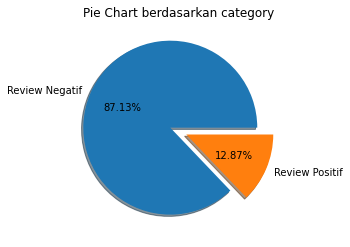

In [43]:
labels= ["Review Negatif", "Review Positif"]
plt.pie(submission.groupby('category').count()['review_id'], labels=labels, shadow=True,explode=(0.1,  0.1), autopct='%1.2f%%')
plt.title("Pie Chart berdasarkan category")